In [1]:
# Core modules
import asyncio

# Non-core modules
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Local modules
from pac_hunter.hunter import fetch_committee_distributions, clean_df
from pac_hunter.states import us_state_to_abbrev, abbrev_to_us_state
try:
    from pac_hunter.constants import OPENFEC_API_KEY
except ImportError:
    OPENFEC_API_KEY = "DEMO_KEY"


c:\Users\Kepler\fraypac\.venv\lib\site-packages\thefuzz\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
# Load relevant data on election deniers, from congressional roll call on Jan 6 2021 and fivethirtyeight's data on 2022 candidates
jan6_house = pd.read_csv("jan6-house-deniers.csv")
jan6_senate = pd.read_csv("jan6-senate-deniers.csv")
jan6_congress = pd.concat([jan6_house.assign(office="Representative"), jan6_senate.assign(office="Senator")], ignore_index=True)
url = "https://raw.githubusercontent.com/fivethirtyeight/data/master/election-deniers/fivethirtyeight_election_deniers.csv"
ballot_deniers = pd.read_csv(url)
ballot_deniers = ballot_deniers.assign(party="r")
ballot_deniers = ballot_deniers.query("Stance != 'Fully accepted'")
ballot_deniers = ballot_deniers.query("Stance != 'No comment'")

In [3]:
# Clean the dataframes for consistent columns
jan6_congress_clean = clean_candidate_df(jan6_congress)
ballot_deniers_clean = clean_candidate_df(ballot_deniers)
jan6_deniers = jan6_congress_clean.query("vote=='yea'")

In [4]:
# Leverage OpenFEC API to collect distributions from a given PAC to election deniers
denier_donations = await fetch_committee_distributions(
    api_key=OPENFEC_API_KEY,
    committee_name="raytheon technologies",
    recipient_names=ballot_deniers_clean["name"].to_list(),
)

Multiple results for committee raytheon technologies, taking the first entry


In [34]:
# The resulting dataframe showing PAC distributions to election deniers
denier_donations.head(5)

,memo_total,committee_name,committee_id,recipient_id,recipient_name,cycle,total,memo_count,count,name,office_sought,id,candidate_id,CAND_ELECTION_YR,FEC_ELECTION_YR,CMTE_TP,CMTE_DSGN,LINKAGE_ID
0,0.0,EMPLOYEES OF RAYTHEON TECHNOLOGIES CORPORATION...,C00097568,C00313247,ROBERT ADERHOLT FOR CONGRESS,2022,7000.0,0,5,"ADERHOLT, ROBERT B. REP.",H,H6AL04098,H6AL04098,2022,2022,H,P,234772
1,0.0,EMPLOYEES OF RAYTHEON TECHNOLOGIES CORPORATION...,C00097568,C00313247,ROBERT ADERHOLT FOR CONGRESS,2020,10000.0,0,4,"ADERHOLT, ROBERT B. REP.",H,H6AL04098,H6AL04098,2022,2022,H,P,234772
2,0.0,EMPLOYEES OF RAYTHEON TECHNOLOGIES CORPORATION...,C00097568,C00313247,ROBERT ADERHOLT FOR CONGRESS,2010,10000.0,0,8,"ADERHOLT, ROBERT B. REP.",H,H6AL04098,H6AL04098,2022,2022,H,P,234772
3,0.0,EMPLOYEES OF RAYTHEON TECHNOLOGIES CORPORATION...,C00097568,C00313247,ROBERT ADERHOLT FOR CONGRESS,2008,10000.0,0,8,"ADERHOLT, ROBERT B. REP.",H,H6AL04098,H6AL04098,2022,2022,H,P,234772
4,0.0,EMPLOYEES OF RAYTHEON TECHNOLOGIES CORPORATION...,C00097568,C00313247,ROBERT ADERHOLT FOR CONGRESS,2006,4000.0,0,4,"ADERHOLT, ROBERT B. REP.",H,H6AL04098,H6AL04098,2022,2022,H,P,234772


In [14]:
# Compact the distribution data by cycle and candidate
denier_donations_by_cycle = denier_donations.groupby(["name", "office_sought", "cycle"]).sum(numeric_only=True).reset_index()
denier_donations_cumulative = denier_donations.groupby(["name", "office_sought"]).sum(numeric_only=True)["total"].reset_index()
denier_donations_cumulative.head(5)

,name,office_sought,total
0,"ADERHOLT, ROBERT B. REP.",H,92000.0
1,"AMODEI, MARK EUGENE",H,8000.0
2,"ARRINGTON, JODEY COOK",H,23000.0
3,"BABIN, BRIAN",H,41000.0
4,"BARR, GARLAND ANDY",H,21500.0


<AxesSubplot: ylabel='name'>

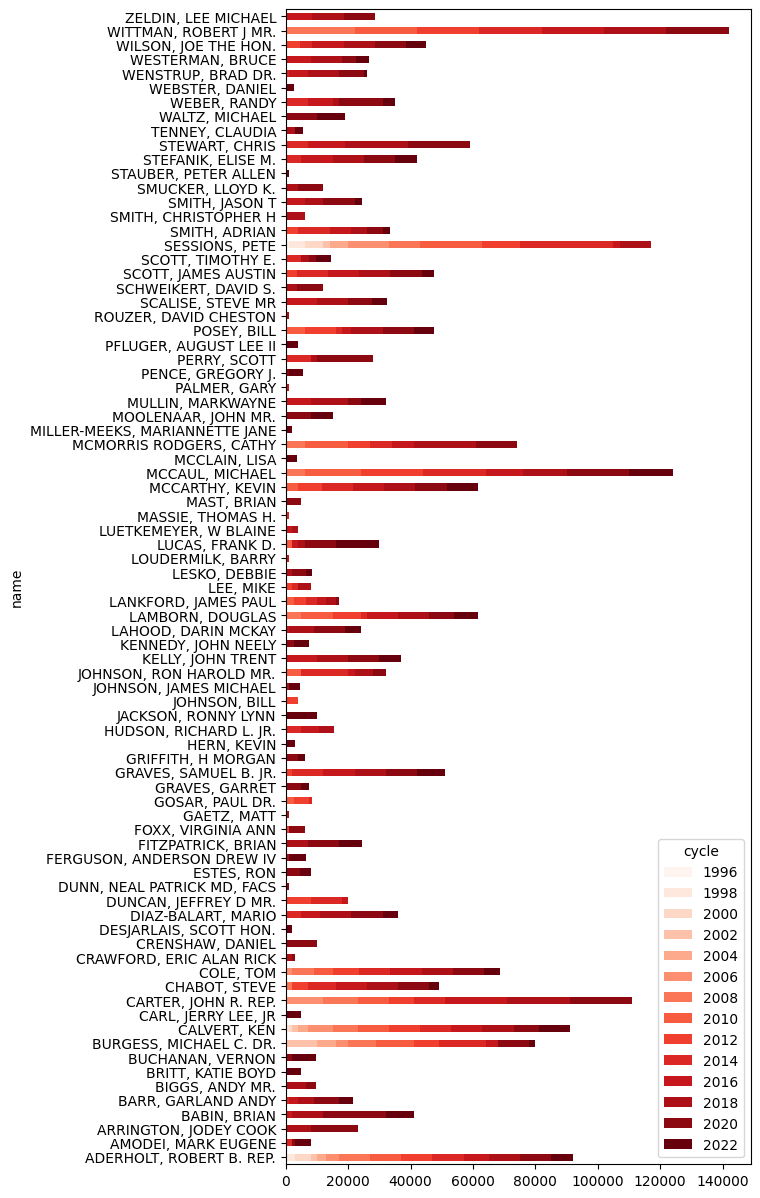

In [20]:
# Plot a stacked barchart showing total donations per candidate
df = denier_donations_by_cycle.pivot(index="name", columns="cycle", values="total")
sns.set_color_codes("muted")
df.plot(kind="barh", stacked=True, figsize=(6, 15), colormap="Reds")

<AxesSubplot: xlabel='cycle', ylabel='name'>

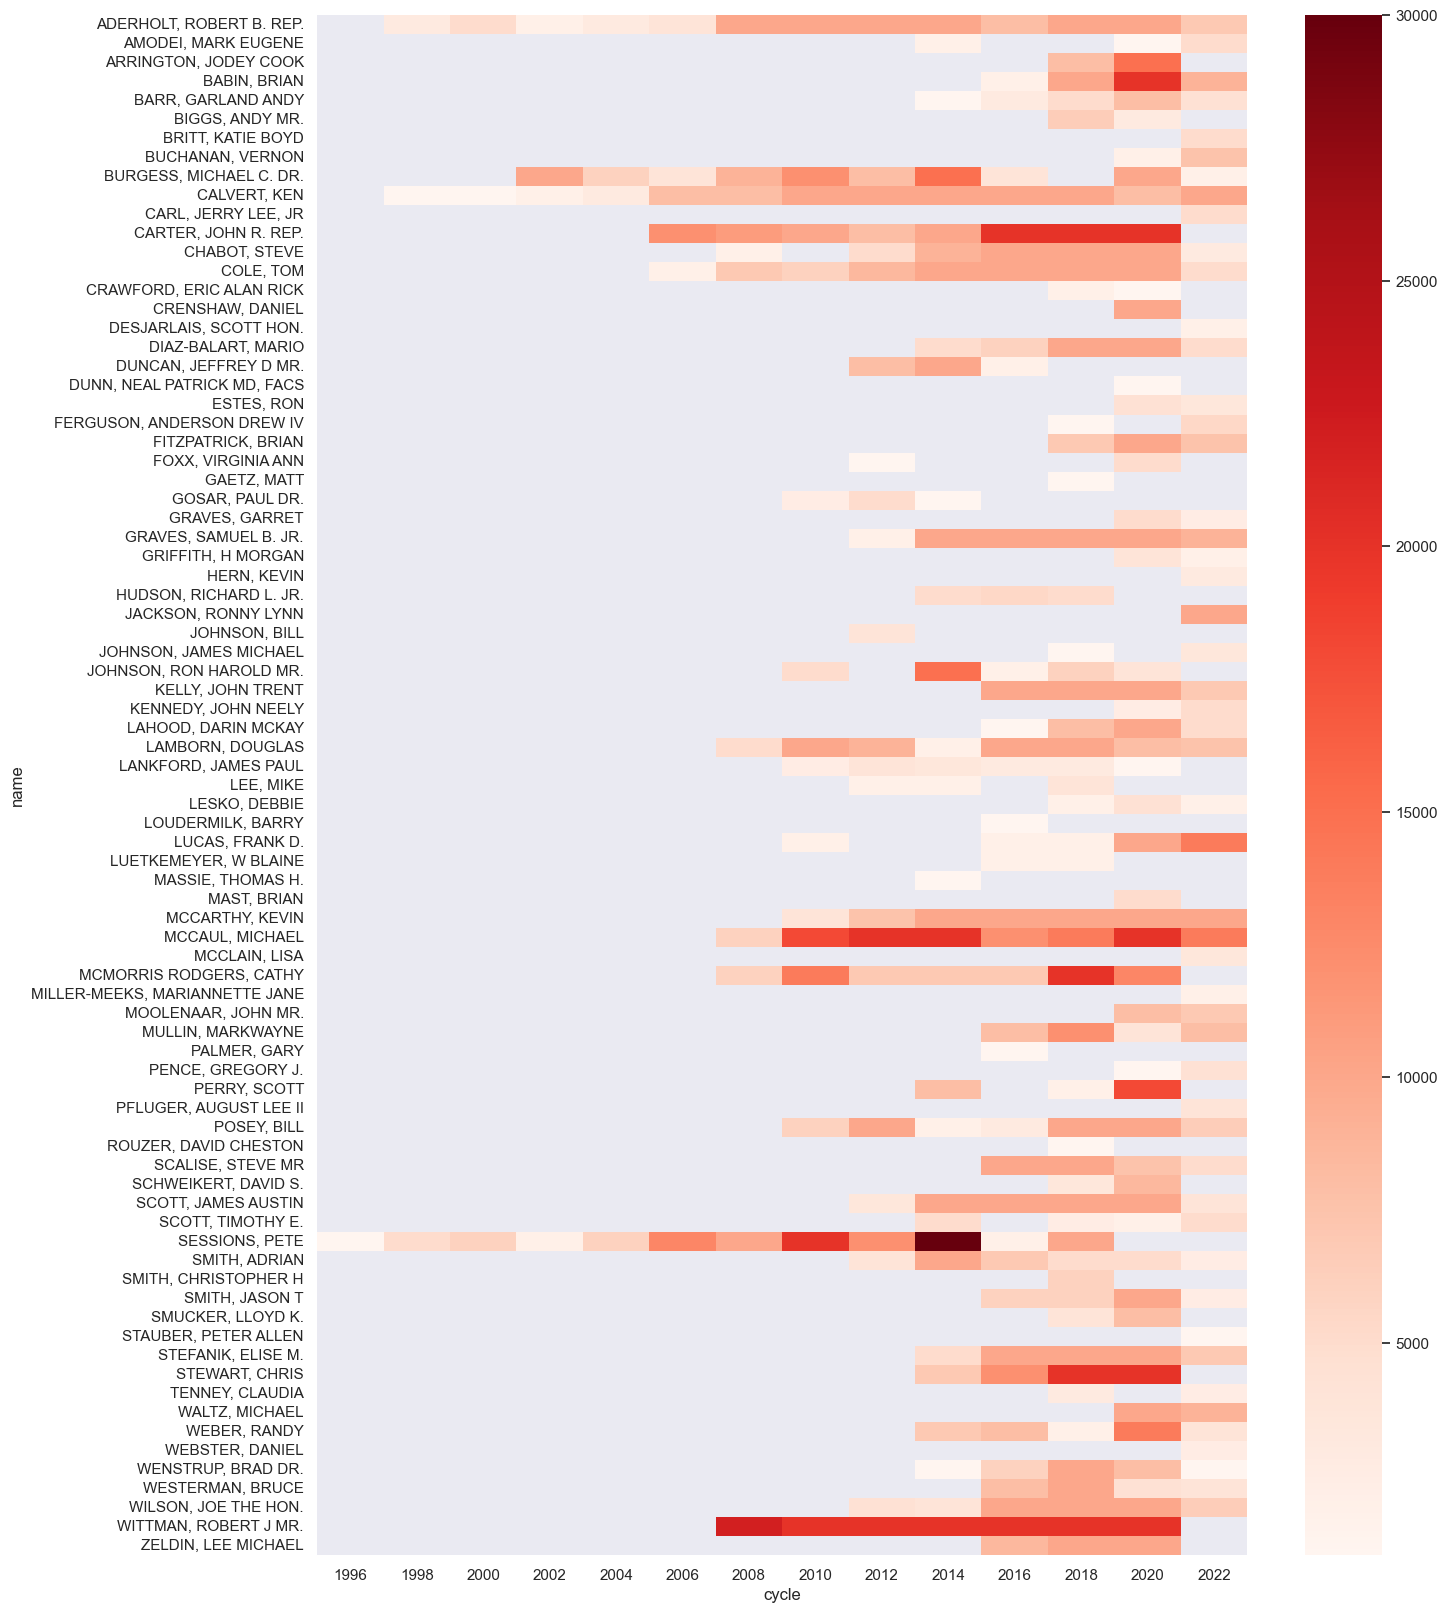

In [33]:
# Plot a heatmap showing donation history of each candidate
f, ax = plt.subplots(figsize=(15, 20))
sns.heatmap(df, ax=ax, yticklabels="auto", cmap="Reds")